In [10]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed, ConvLSTM2D, BatchNormalization
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from keras.optimizers import SGD, Adam, Adadelta, Adagrad, Adamax, RMSprop, Nadam
import os
from sklearn.metrics import auc, accuracy_score, confusion_matrix
import seaborn as sns
from keras.regularizers import l2
import talos as ta
from collections import OrderedDict
base = './'

# total acceleration / body acceleration / body gyroscope
filenames = ['total_acc_%s_init.txt'%(i) for i in ['x','y','z']]
filenames += ['body_acc_%s_init.txt'%(i) for i in ['x','y','z']]
filenames += ['body_gyro_%s_init.txt'%(i) for i in ['x','y','z']]

X_train = []
for path in filenames:
    data = pd.read_csv(os.path.join(base,'Train/Inertial_signals',path), header=None, delim_whitespace=True)
    X_train.append(data)
X_train = np.dstack(X_train)

with open(os.path.join(base,'Train/y_train_init.txt'), 'r') as f:
    train = f.readlines()
y_train = [int(i.replace('/n',''))-1 for i in train]
y_train = to_categorical(y_train)

X_val = []
for path in filenames:
    data = pd.read_csv(os.path.join(base,'Test/Inertial_signals',path), header=None, delim_whitespace=True)
    X_val.append(data)
X_val = np.dstack(X_val)

with open(os.path.join(base,'Test/y_test_init.txt'), 'r') as f:
    val = f.readlines()

y_val = [int(i.replace('/n',''))-1 for i in val]
y_val = to_categorical(y_val)

In [3]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


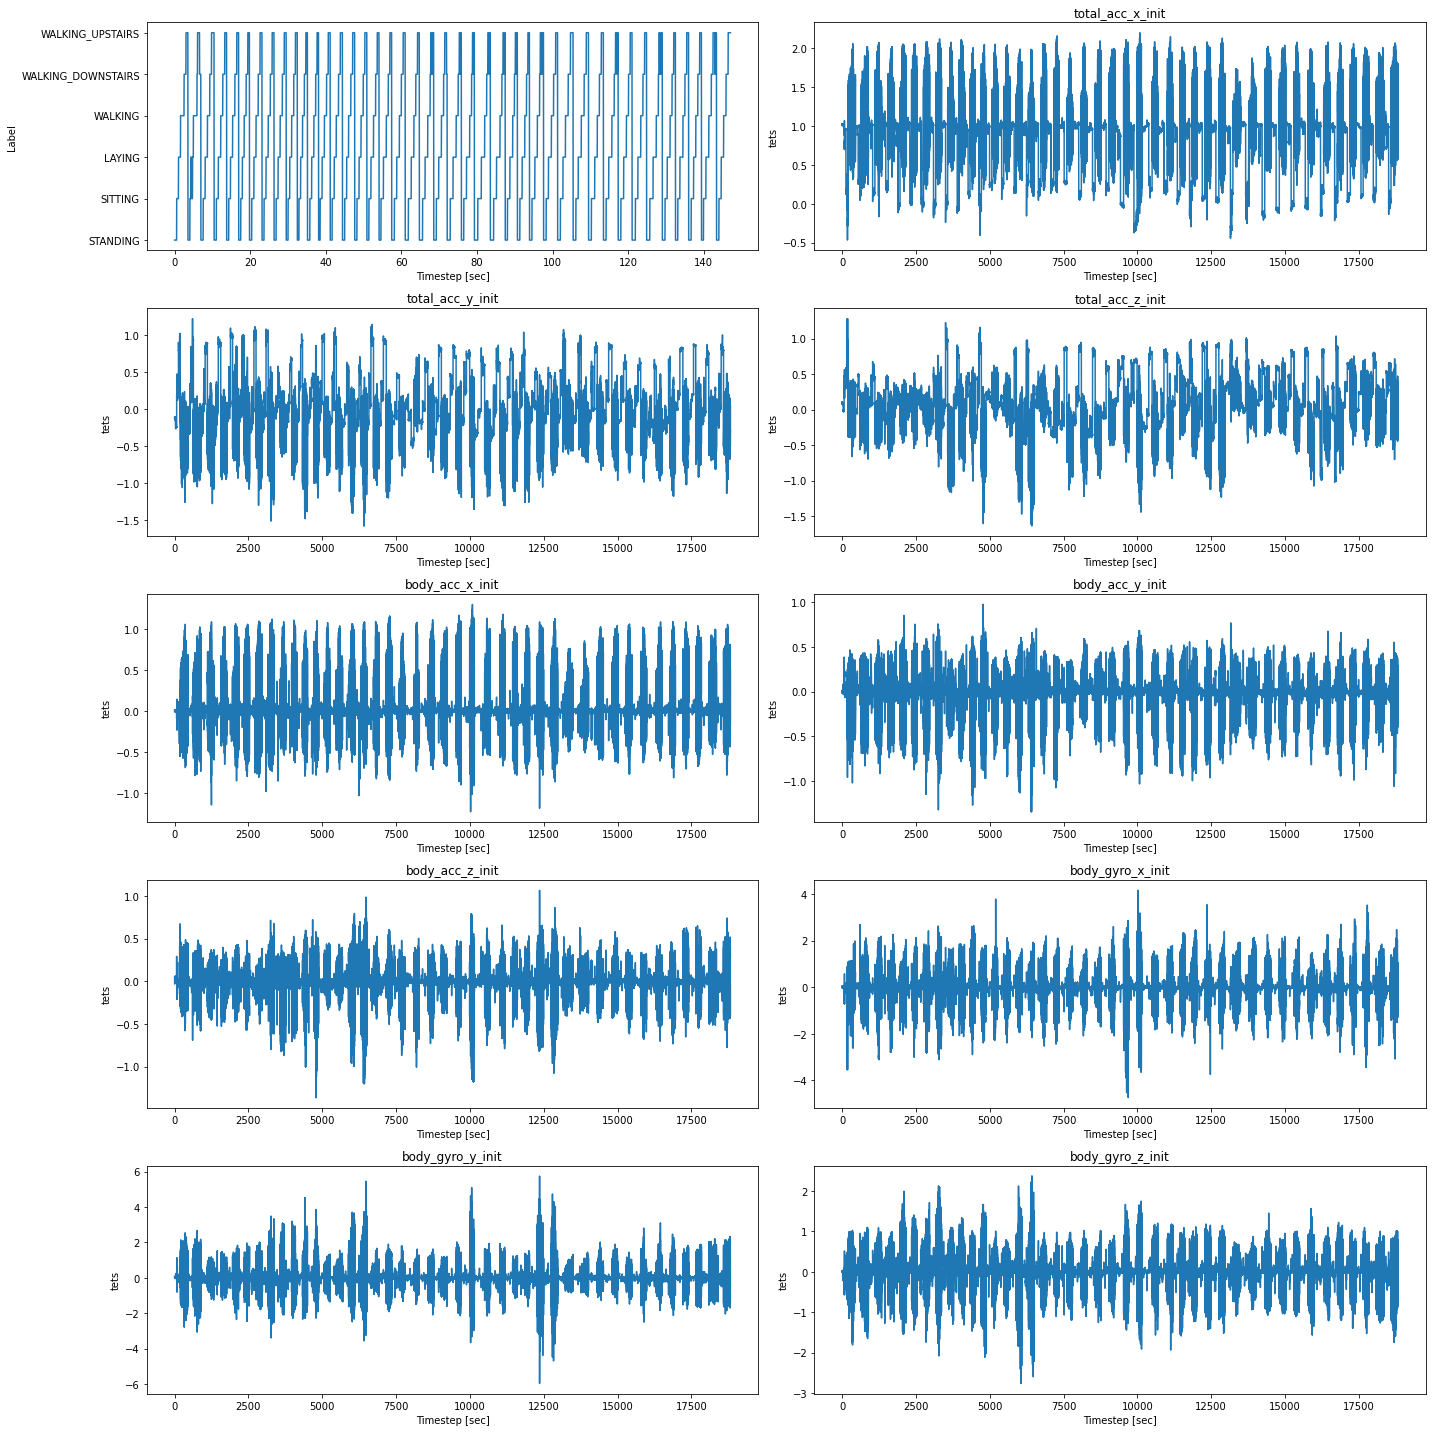

In [38]:
plt.figure(figsize=(20,20))
all_res = X_train.reshape(-1,9)
label_res = ['STANDING','SITTING','LAYING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

for i in range(10):
    plt.subplot(5,2,i+1)
    if i ==0:
        plt.plot([k*0.02 for k in range(len(train))],train)
        plt.xlabel('Timestep [sec]')
        plt.ylabel('Label')
        plt.yticks(np.arange(6), label_res)
    else:
        plt.plot([k*0.02 for k in range(len(all_res))],all_res[:,i-1])
        plt.xlabel('Timestep [sec]')
        plt.ylabel('tets')
        plt.title(filenames[i-1].replace('.txt',''))
plt.tight_layout()

In [39]:
verbose, epochs, batch_size = 0, 100, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# # reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1, n_length, n_features))

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, 
                     kernel_size=(1,3), 
                     activation='elu', 
                     kernel_regularizer=l2(0.001),
#                      bias_regularizer=l2(0.001),
                     input_shape=(n_steps, 1, n_length, n_features)))
model.add(BatchNormalization())
model.add(Dense(128, activation='elu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu', kernel_regularizer=l2(0.001)))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val))

# evaluate model
_, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 9s 1ms/step - loss: 0.8439 - accuracy: 0.8222 - val_loss: 1.5198 - val_accuracy: 0.4920
Epoch 2/100
7352/7352 [==============================] - 10s 1ms/step - loss: 0.5010 - accuracy: 0.9282 - val_loss: 1.1782 - val_accuracy: 0.6410
Epoch 3/100
7352/7352 [==============================] - 10s 1ms/step - loss: 0.4482 - accuracy: 0.9354 - val_loss: 0.7355 - val_accuracy: 0.8205
Epoch 4/100
7352/7352 [==============================] - 10s 1ms/step - loss: 0.3853 - accuracy: 0.9382 - val_loss: 0.6101 - val_accuracy: 0.8656
Epoch 5/100
7352/7352 [==============================] - 10s 1ms/step - loss: 0.3443 - accuracy: 0.9455 - val_loss: 0.5548 - val_accuracy: 0.8853
Epoch 6/100
7352/7352 [==============================] - 11s 1ms/step - loss: 0.3090 - accuracy: 0.9444 - val_loss: 0.4946 - val_accuracy: 0.9036
Epoch 7/100
7352/7352 [==============================] - 12s 2ms/step - loss:

In [40]:
print(accuracy)

0.9110960364341736


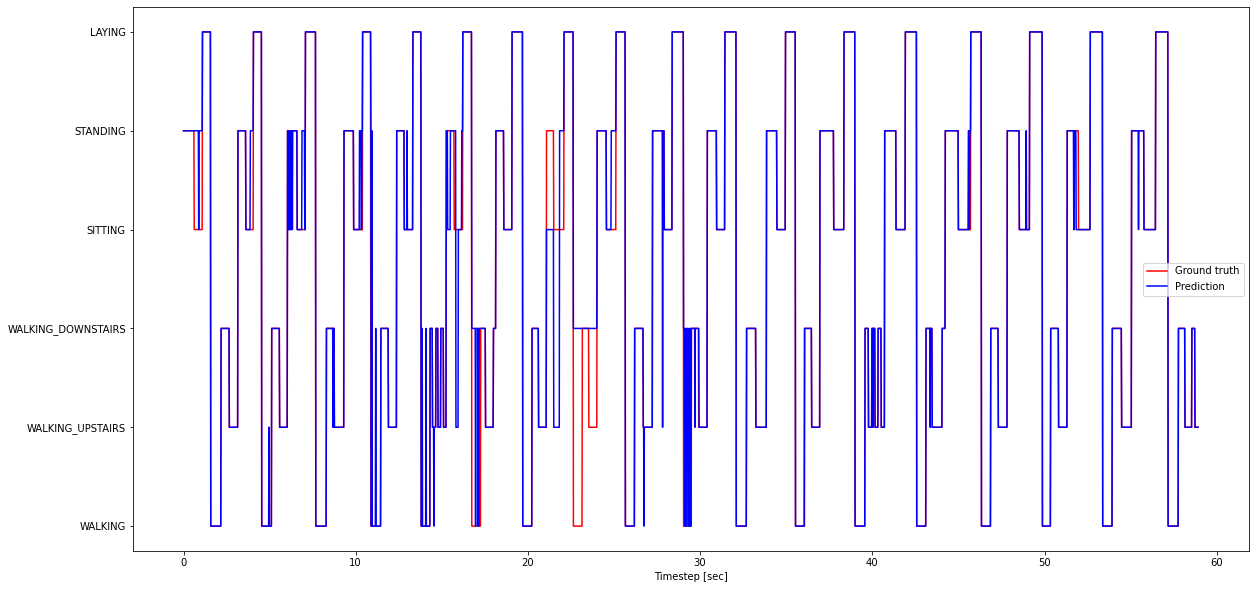

In [41]:
gt = [np.argmax(k, axis=None, out=None) for k in y_val]
pred = [np.argmax(k, axis=None, out=None) for k in model.predict(X_val, verbose=0)]
label_res = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']

plt.figure(figsize=(20,10))
plt.plot([k*0.02 for k in range(len(gt))],gt,'r', label='Ground truth')
plt.plot([k*0.02 for k in range(len(pred))],pred,'b', label='Prediction')
plt.xlabel('Timestep [sec]')
plt.yticks(np.arange(6), label_res)
plt.legend()

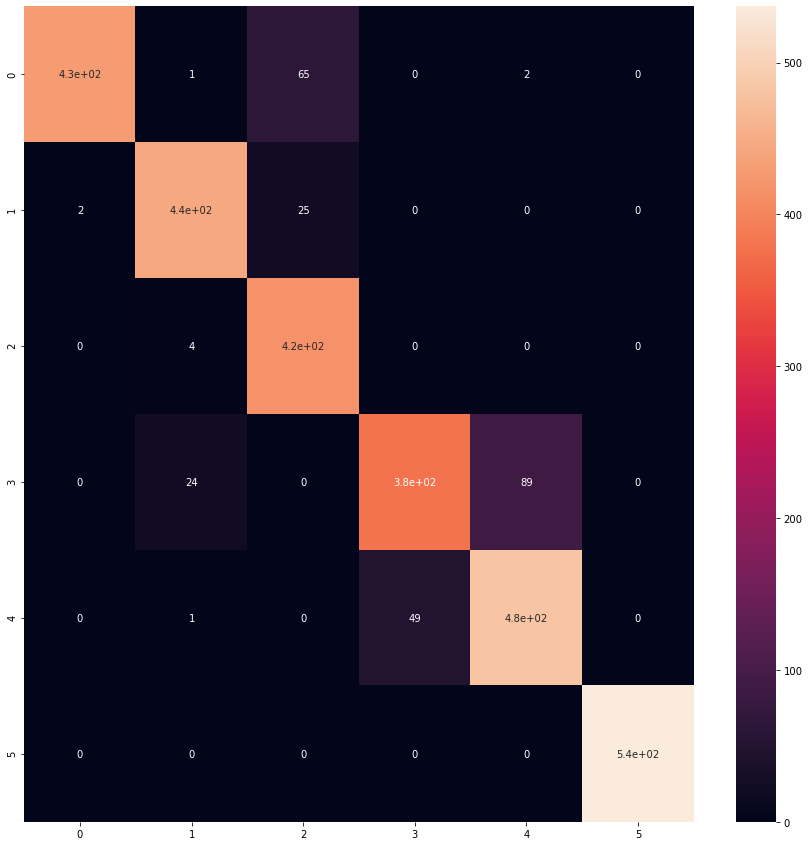

In [42]:
res = confusion_matrix(gt, pred)

confusion = pd.DataFrame(res, index = [i for i in range(len(np.unique(gt)))], columns = [i for i in range(len(np.unique(gt)))])
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(confusion, annot=True)

Text(0, 0.5, 'Loss')

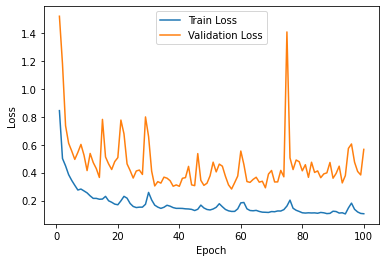

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']

train_loss_plot, = plt.plot(range(1, len(loss)+1), loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation Loss')
_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

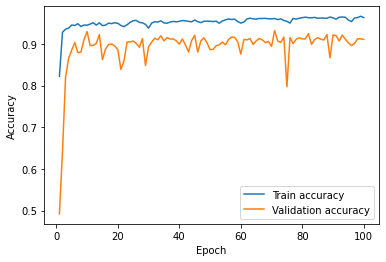

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_acc_plot, = plt.plot(range(1, len(acc)+1), acc, label='Train accuracy')
val_acc_plot, = plt.plot(range(1, len(acc)+1), val_acc, label='Validation accuracy')
_ = plt.legend(handles=[train_acc_plot, val_acc_plot])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# People classification

In [54]:
X_train = []
for path in filenames:
    data = pd.read_csv(os.path.join(base,'Train/Inertial_signals',path), header=None, delim_whitespace=True)
    X_train.append(data)
X_train = np.dstack(X_train)

with open(os.path.join(base,'Train/subject_train_init.txt'), 'r') as f:
    y_train_people = f.readlines()
y_train_people = [int(i.replace('\n',''))-1 for i in y_train_people]

X_val = []
for path in filenames:
    data = pd.read_csv(os.path.join(base,'Test/Inertial_signals',path), header=None, delim_whitespace=True)
    X_val.append(data)
X_val = np.dstack(X_val)

with open(os.path.join(base,'Test/subject_test_init.txt'), 'r') as f:
    y_val_people = f.readlines()
y_val_people = [int(i.replace('\n',''))-1 for i in y_val_people]

data = np.concatenate((X_train, X_val), axis=0)
label = to_categorical(np.concatenate((y_train_people, y_val_people), axis=0))

X_train, X_val, y_train_people, y_val_people = train_test_split(data, label, test_size=0.25, random_state=42)

In [56]:
verbose, epochs, batch_size = 0, 1000, 64
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_people.shape[1]

# Reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1, n_length, n_features))

# define model
model_people = Sequential()
model_people.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model_people.add(Dropout(0.5))
model_people.add(Flatten())
model_people.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_people.add(Dense(n_outputs, activation='softmax'))
model_people.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history_people = model_people.fit(X_train, y_train_people, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data=(X_val, y_val_people))

# evaluate model
_, accuracy_people = model_people.evaluate(X_val, y_val_people, batch_size=batch_size)

Train on 7724 samples, validate on 2575 samples
Epoch 1/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 3.3644 - accuracy: 0.1374 - val_loss: 2.7717 - val_accuracy: 0.2365
Epoch 2/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 2.4917 - accuracy: 0.3202 - val_loss: 2.3053 - val_accuracy: 0.3755
Epoch 3/1000
7724/7724 [==============================] - 12s 1ms/step - loss: 2.1391 - accuracy: 0.4269 - val_loss: 2.0281 - val_accuracy: 0.4571
Epoch 4/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 1.9299 - accuracy: 0.4859 - val_loss: 1.8384 - val_accuracy: 0.5041
Epoch 5/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 1.8032 - accuracy: 0.5220 - val_loss: 1.7970 - val_accuracy: 0.5355
Epoch 6/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 1.6898 - accuracy: 0.5602 - val_loss: 1.6877 - val_accuracy: 0.5654
Epoch 7/1000
7724/7724 [==============================] - 11s 1ms/step

7724/7724 [==============================] - 11s 1ms/step - loss: 0.8548 - accuracy: 0.7918 - val_loss: 1.0103 - val_accuracy: 0.7643
Epoch 57/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.8301 - accuracy: 0.8063 - val_loss: 1.0674 - val_accuracy: 0.7507
Epoch 58/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.8537 - accuracy: 0.7952 - val_loss: 1.0274 - val_accuracy: 0.7464
Epoch 59/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.8290 - accuracy: 0.8017 - val_loss: 1.0589 - val_accuracy: 0.7433
Epoch 60/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.8397 - accuracy: 0.8001 - val_loss: 1.0001 - val_accuracy: 0.7829
Epoch 61/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.8081 - accuracy: 0.8053 - val_loss: 1.0111 - val_accuracy: 0.7627
Epoch 62/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.7841 - accuracy: 0.8189 - val_loss: 1.0039 -

7724/7724 [==============================] - 11s 1ms/step - loss: 0.5227 - accuracy: 0.8993 - val_loss: 0.9666 - val_accuracy: 0.8311
Epoch 167/1000
7724/7724 [==============================] - 12s 1ms/step - loss: 0.5143 - accuracy: 0.8991 - val_loss: 0.9394 - val_accuracy: 0.8346
Epoch 168/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.5134 - accuracy: 0.9006 - val_loss: 0.9719 - val_accuracy: 0.8179
Epoch 169/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.4998 - accuracy: 0.9015 - val_loss: 0.9294 - val_accuracy: 0.8322
Epoch 170/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.4820 - accuracy: 0.9052 - val_loss: 0.9374 - val_accuracy: 0.8373
Epoch 171/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.5119 - accuracy: 0.8982 - val_loss: 0.9429 - val_accuracy: 0.8256
Epoch 172/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.5256 - accuracy: 0.8985 - val_loss: 0.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.4561 - accuracy: 0.9179 - val_loss: 0.9717 - val_accuracy: 0.8408
Epoch 222/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4347 - accuracy: 0.9227 - val_loss: 0.9404 - val_accuracy: 0.8423
Epoch 223/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4575 - accuracy: 0.9135 - val_loss: 0.9308 - val_accuracy: 0.8427
Epoch 224/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4551 - accuracy: 0.9183 - val_loss: 0.9712 - val_accuracy: 0.8408
Epoch 225/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4507 - accuracy: 0.9158 - val_loss: 0.9173 - val_accuracy: 0.8478
Epoch 226/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.4410 - accuracy: 0.9165 - val_loss: 0.9446 - val_accuracy: 0.8369
Epoch 227/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.4442 - accuracy: 0.9191 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.4102 - accuracy: 0.9323 - val_loss: 1.0153 - val_accuracy: 0.8377
Epoch 277/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4234 - accuracy: 0.9271 - val_loss: 0.9522 - val_accuracy: 0.8532
Epoch 278/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4059 - accuracy: 0.9307 - val_loss: 0.9685 - val_accuracy: 0.8431
Epoch 279/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4137 - accuracy: 0.9296 - val_loss: 0.9251 - val_accuracy: 0.8567
Epoch 280/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4166 - accuracy: 0.9293 - val_loss: 0.9688 - val_accuracy: 0.8458
Epoch 281/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4303 - accuracy: 0.9272 - val_loss: 1.0398 - val_accuracy: 0.8260
Epoch 282/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4155 - accuracy: 0.9307 - val_loss: 0.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.3921 - accuracy: 0.9351 - val_loss: 1.0245 - val_accuracy: 0.8532
Epoch 332/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3884 - accuracy: 0.9379 - val_loss: 1.0154 - val_accuracy: 0.8478
Epoch 333/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3760 - accuracy: 0.9395 - val_loss: 1.0136 - val_accuracy: 0.8517
Epoch 334/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3989 - accuracy: 0.9377 - val_loss: 1.1025 - val_accuracy: 0.8357
Epoch 335/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4224 - accuracy: 0.9285 - val_loss: 0.9368 - val_accuracy: 0.8555
Epoch 336/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3948 - accuracy: 0.9375 - val_loss: 1.0296 - val_accuracy: 0.8485
Epoch 337/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.4252 - accuracy: 0.9281 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.3412 - accuracy: 0.9489 - val_loss: 1.0038 - val_accuracy: 0.8583
Epoch 387/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3436 - accuracy: 0.9459 - val_loss: 0.9538 - val_accuracy: 0.8610
Epoch 388/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3399 - accuracy: 0.9461 - val_loss: 0.9692 - val_accuracy: 0.8594
Epoch 389/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3744 - accuracy: 0.9379 - val_loss: 1.0393 - val_accuracy: 0.8439
Epoch 390/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3601 - accuracy: 0.9410 - val_loss: 0.9665 - val_accuracy: 0.8509
Epoch 391/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3600 - accuracy: 0.9452 - val_loss: 1.0571 - val_accuracy: 0.8509
Epoch 392/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3712 - accuracy: 0.9419 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.3684 - accuracy: 0.9416 - val_loss: 1.0098 - val_accuracy: 0.8528
Epoch 442/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3288 - accuracy: 0.9551 - val_loss: 1.0450 - val_accuracy: 0.8524
Epoch 443/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3303 - accuracy: 0.9524 - val_loss: 1.0221 - val_accuracy: 0.8610
Epoch 444/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3221 - accuracy: 0.9522 - val_loss: 0.9614 - val_accuracy: 0.8598
Epoch 445/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3113 - accuracy: 0.9546 - val_loss: 1.0054 - val_accuracy: 0.8606
Epoch 446/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3346 - accuracy: 0.9503 - val_loss: 1.0323 - val_accuracy: 0.8513
Epoch 447/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3611 - accuracy: 0.9404 - val_loss: 1.

7724/7724 [==============================] - 10s 1ms/step - loss: 0.3500 - accuracy: 0.9492 - val_loss: 1.1047 - val_accuracy: 0.8462
Epoch 497/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.3346 - accuracy: 0.9530 - val_loss: 1.1056 - val_accuracy: 0.8447
Epoch 498/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.3043 - accuracy: 0.9595 - val_loss: 1.0475 - val_accuracy: 0.8687
Epoch 499/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.3021 - accuracy: 0.9568 - val_loss: 1.0794 - val_accuracy: 0.8641
Epoch 500/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.3361 - accuracy: 0.9482 - val_loss: 1.0439 - val_accuracy: 0.8621
Epoch 501/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.3151 - accuracy: 0.9578 - val_loss: 1.0471 - val_accuracy: 0.8649
Epoch 502/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.3255 - accuracy: 0.9518 - val_loss: 1.

7724/7724 [==============================] - 13s 2ms/step - loss: 0.3251 - accuracy: 0.9525 - val_loss: 1.0113 - val_accuracy: 0.8707
Epoch 552/1000
7724/7724 [==============================] - 13s 2ms/step - loss: 0.3073 - accuracy: 0.9578 - val_loss: 1.1510 - val_accuracy: 0.8614
Epoch 553/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3276 - accuracy: 0.9522 - val_loss: 1.0209 - val_accuracy: 0.8633
Epoch 554/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3194 - accuracy: 0.9505 - val_loss: 1.1150 - val_accuracy: 0.8551
Epoch 555/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3114 - accuracy: 0.9579 - val_loss: 1.1206 - val_accuracy: 0.8466
Epoch 556/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.2925 - accuracy: 0.9626 - val_loss: 1.1168 - val_accuracy: 0.8602
Epoch 557/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3179 - accuracy: 0.9521 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.3062 - accuracy: 0.9623 - val_loss: 1.0553 - val_accuracy: 0.8621
Epoch 607/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3101 - accuracy: 0.9597 - val_loss: 1.1634 - val_accuracy: 0.8532
Epoch 608/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3234 - accuracy: 0.9525 - val_loss: 1.1725 - val_accuracy: 0.8435
Epoch 609/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3114 - accuracy: 0.9571 - val_loss: 1.1310 - val_accuracy: 0.8645
Epoch 610/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3080 - accuracy: 0.9584 - val_loss: 1.1087 - val_accuracy: 0.8579
Epoch 611/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3206 - accuracy: 0.9547 - val_loss: 1.0582 - val_accuracy: 0.8680
Epoch 612/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2962 - accuracy: 0.9645 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.3097 - accuracy: 0.9577 - val_loss: 1.1287 - val_accuracy: 0.8555
Epoch 662/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3089 - accuracy: 0.9605 - val_loss: 1.0793 - val_accuracy: 0.8617
Epoch 663/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3081 - accuracy: 0.9584 - val_loss: 1.1312 - val_accuracy: 0.8590
Epoch 664/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2962 - accuracy: 0.9617 - val_loss: 1.0933 - val_accuracy: 0.8610
Epoch 665/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3145 - accuracy: 0.9591 - val_loss: 1.1038 - val_accuracy: 0.8691
Epoch 666/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3035 - accuracy: 0.9597 - val_loss: 1.1104 - val_accuracy: 0.8738
Epoch 667/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3049 - accuracy: 0.9590 - val_loss: 1.

7724/7724 [==============================] - 13s 2ms/step - loss: 0.2919 - accuracy: 0.9603 - val_loss: 1.1540 - val_accuracy: 0.8602
Epoch 717/1000
7724/7724 [==============================] - 13s 2ms/step - loss: 0.3004 - accuracy: 0.9613 - val_loss: 1.2495 - val_accuracy: 0.8594
Epoch 718/1000
7724/7724 [==============================] - 13s 2ms/step - loss: 0.3111 - accuracy: 0.9586 - val_loss: 1.2331 - val_accuracy: 0.8676
Epoch 719/1000
7724/7724 [==============================] - 13s 2ms/step - loss: 0.3235 - accuracy: 0.9542 - val_loss: 1.1459 - val_accuracy: 0.8509
Epoch 720/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.3030 - accuracy: 0.9605 - val_loss: 1.1409 - val_accuracy: 0.8548
Epoch 721/1000
7724/7724 [==============================] - 13s 2ms/step - loss: 0.3088 - accuracy: 0.9608 - val_loss: 1.1525 - val_accuracy: 0.8544
Epoch 722/1000
7724/7724 [==============================] - 18s 2ms/step - loss: 0.3176 - accuracy: 0.9555 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.2633 - accuracy: 0.9701 - val_loss: 1.1349 - val_accuracy: 0.8707
Epoch 772/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2488 - accuracy: 0.9729 - val_loss: 1.1724 - val_accuracy: 0.8672
Epoch 773/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2679 - accuracy: 0.9679 - val_loss: 1.1541 - val_accuracy: 0.8590
Epoch 774/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2919 - accuracy: 0.9595 - val_loss: 1.1051 - val_accuracy: 0.8594
Epoch 775/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2989 - accuracy: 0.9608 - val_loss: 1.1348 - val_accuracy: 0.8583
Epoch 776/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2899 - accuracy: 0.9599 - val_loss: 1.0772 - val_accuracy: 0.8660
Epoch 777/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2779 - accuracy: 0.9661 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.2395 - accuracy: 0.9716 - val_loss: 1.2163 - val_accuracy: 0.8614
Epoch 827/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2901 - accuracy: 0.9584 - val_loss: 1.2496 - val_accuracy: 0.8567
Epoch 828/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2685 - accuracy: 0.9644 - val_loss: 1.2348 - val_accuracy: 0.8711
Epoch 829/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2648 - accuracy: 0.9682 - val_loss: 1.2408 - val_accuracy: 0.8645
Epoch 830/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2640 - accuracy: 0.9653 - val_loss: 1.2427 - val_accuracy: 0.8559
Epoch 831/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.3017 - accuracy: 0.9582 - val_loss: 1.1693 - val_accuracy: 0.8687
Epoch 832/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2951 - accuracy: 0.9609 - val_loss: 1.

7724/7724 [==============================] - 11s 1ms/step - loss: 0.2677 - accuracy: 0.9691 - val_loss: 1.2062 - val_accuracy: 0.8664
Epoch 882/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.2323 - accuracy: 0.9790 - val_loss: 1.1999 - val_accuracy: 0.8680
Epoch 883/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.2396 - accuracy: 0.9731 - val_loss: 1.2524 - val_accuracy: 0.8610
Epoch 884/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.2784 - accuracy: 0.9622 - val_loss: 1.3199 - val_accuracy: 0.8536
Epoch 885/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2753 - accuracy: 0.9645 - val_loss: 1.2476 - val_accuracy: 0.8691
Epoch 886/1000
7724/7724 [==============================] - 10s 1ms/step - loss: 0.2468 - accuracy: 0.9735 - val_loss: 1.1983 - val_accuracy: 0.8672
Epoch 887/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2581 - accuracy: 0.9672 - val_loss: 1.

7724/7724 [==============================] - 12s 2ms/step - loss: 0.2749 - accuracy: 0.9662 - val_loss: 1.2467 - val_accuracy: 0.8567
Epoch 991/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.2454 - accuracy: 0.9745 - val_loss: 1.2337 - val_accuracy: 0.8633
Epoch 992/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2339 - accuracy: 0.9763 - val_loss: 1.1829 - val_accuracy: 0.8722
Epoch 993/1000
7724/7724 [==============================] - 12s 1ms/step - loss: 0.2743 - accuracy: 0.9653 - val_loss: 1.2047 - val_accuracy: 0.8610
Epoch 994/1000
7724/7724 [==============================] - 12s 2ms/step - loss: 0.2558 - accuracy: 0.9707 - val_loss: 1.2768 - val_accuracy: 0.8458
Epoch 995/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2741 - accuracy: 0.9656 - val_loss: 1.2129 - val_accuracy: 0.8668
Epoch 996/1000
7724/7724 [==============================] - 11s 1ms/step - loss: 0.2683 - accuracy: 0.9675 - val_loss: 1.

In [57]:
print(accuracy_people)

0.8714563250541687


In [58]:
model_people.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 1, 30, 64)         56320     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               983552    
_________________________________________________________________
dense_16 (Dense)             (None, 30)                15390     
Total params: 1,055,262
Trainable params: 1,055,262
Non-trainable params: 0
_________________________________________________________________


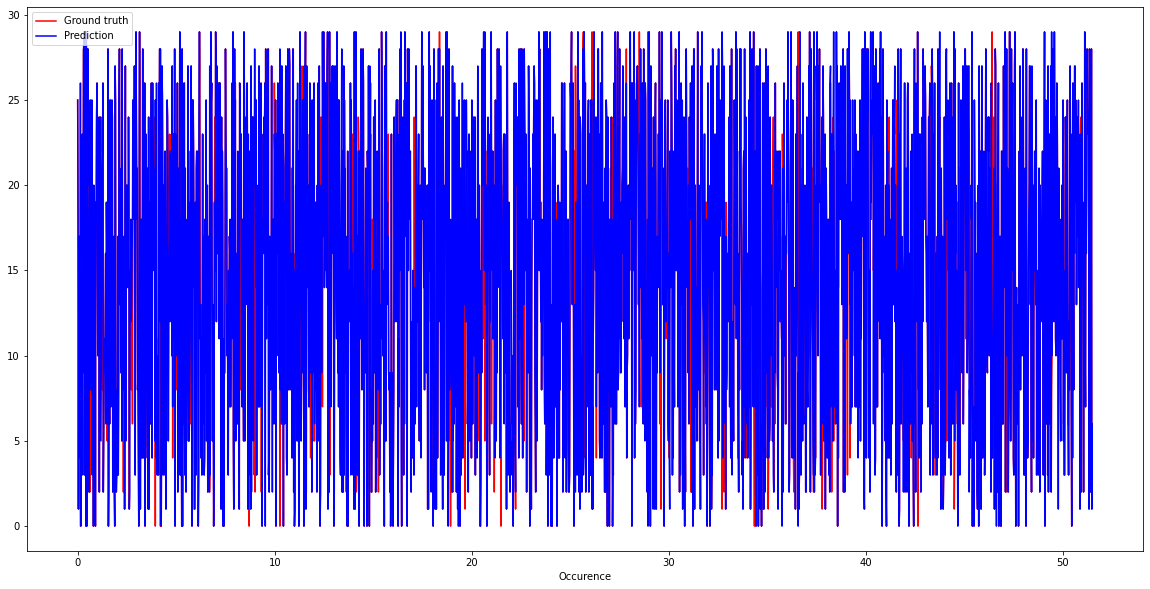

In [59]:
gt_people = [np.argmax(k, axis=None, out=None) for k in y_val_people]
pred_people = [np.argmax(k, axis=None, out=None) for k in model_people.predict(X_val, verbose=0)]

plt.figure(figsize=(20,10))
plt.plot([k*0.02 for k in range(len(gt_people))],gt_people,'r', label='Ground truth')
plt.plot([k*0.02 for k in range(len(pred_people))],pred_people,'b', label='Prediction')
plt.xlabel('Occurence')
# plt.yticks(np.arange(6), label_res)
plt.legend()

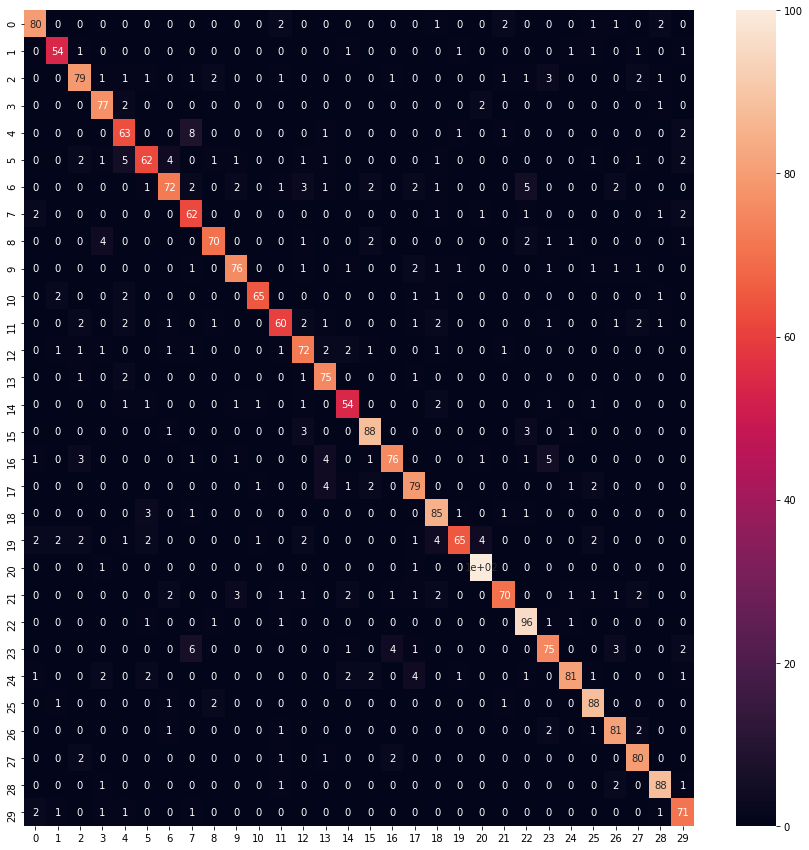

In [60]:
res = confusion_matrix(gt_people, pred_people)

confusion = pd.DataFrame(res, index = [i for i in range(len(np.unique(gt_people)))], columns = [i for i in range(len(np.unique(gt_people)))])
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(confusion, annot=True)

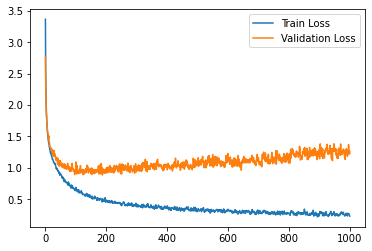

In [61]:
loss = history_people.history['loss']
val_loss = history_people.history['val_loss']

train_loss_plot, = plt.plot(range(1, len(loss)+1), loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation Loss')
_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

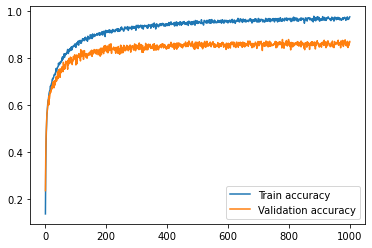

In [62]:
acc = history_people.history['accuracy']
val_acc = history_people.history['val_accuracy']

train_acc_plot, = plt.plot(range(1, len(acc)+1), acc, label='Train accuracy')
val_acc_plot, = plt.plot(range(1, len(acc)+1), val_acc, label='Validation accuracy')
_ = plt.legend(handles=[train_acc_plot, val_acc_plot])

# Grid search

In [ ]:
# params_gridcv = {'estimator__max_depth':[i for i in range(1,12)],
#                 'estimator__min_child_weight':[i for i in range(1,12)],
#                 'estimator__learning_rate':[.1, .05, .01, .005],
#                 'estimator__subsample':[i/10. for i in range(1,11)],
#                 'estimator__colsample_bytree':[i/10 for i in range(1,11)],
#                 'estimator__objective':['reg:squarederror'],
#                 'estimator__n_estimators':[1000],
#                 'estimator__eval_metric':['rmse', 'mae']}

In [ ]:
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(data, label)

In [30]:
params_talos = {# 'lr': [0.01, 0.1, 1, 10],
                'batch_size': [10, 50, 100],
                'epochs': [100,250,500,1000],
                'dropout': [0, 0.1, 0.25, 5],
                'kernel_size':[(1,3)],
#     ,(3,1),(3,3),(5,5)],
#                 'weight_regulizer':[None],
#                 'emb_output_dims': [None],
#                 'shape':['brick','long_funnel'],
                'optimizer': [Adam, Nadam, RMSprop],
                'loss': ['categorical_crossentropy'],
                'activation':['relu', 'elu'],
                'last_activation': ['softmax','sigmoid']}

In [31]:
X_train = []
for path in filenames:
    data = pd.read_csv(os.path.join(base,'Train/Inertial_signals',path), header=None, delim_whitespace=True)
    X_train.append(data)
X_train = np.dstack(X_train)

with open(os.path.join(base,'Train/subject_train_init.txt'), 'r') as f:
    y_train_people = f.readlines()
y_train_people = [int(i.replace('\n',''))-1 for i in y_train_people]

X_val = []
for path in filenames:
    data = pd.read_csv(os.path.join(base,'Test/Inertial_signals',path), header=None, delim_whitespace=True)
    X_val.append(data)
X_val = np.dstack(X_val)

with open(os.path.join(base,'Test/subject_test_init.txt'), 'r') as f:
    y_val_people = f.readlines()
y_val_people = [int(i.replace('\n',''))-1 for i in y_val_people]

data = np.concatenate((X_train, X_val), axis=0)
label = to_categorical(np.concatenate((y_train_people, y_val_people), axis=0))

X_train, X_val, y_train_people, y_val_people = train_test_split(data, label, test_size=0.25, random_state=42)

n_steps, n_length, n_features = 4, 32, X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, 1, n_length, n_features))

In [ ]:
def model_tuning(X_train, y_train, X_val, y_val, params):
    # define model
    model_people = Sequential()
    model_people.add(ConvLSTM2D(filters=64,
                                kernel_size = params['kernel_size'],
                                activation = params['activation'],
                                input_shape = X_train.shape[1:]))
    model_people.add(Dropout(params['dropout']))
    model_people.add(Dense(128, activation=params['activation'], kernel_regularizer=l2(0.001)))
    model_people.add(Dropout(params['dropout']))
    model_people.add(Flatten())
    model_people.add(Dense(30, activation=params['last_activation']))
    model_people.compile(loss=params['loss'], optimizer='adam', metrics=['accuracy'])

    # fit network
    history_people = model_people.fit(X_train, y_train, 
                                      epochs=params['epochs'], 
                                      batch_size=params['batch_size'],
                                      verbose = 0,
                                      validation_data = (X_val, y_val))
    return history_people, model_people

exp = ta.Scan(X_train, y_train_people,
              model = model_tuning, 
              params = OrderedDict(params_talos), 
              experiment_name = 'test')

In [ ]:
exp.data.head()